# LeNet-5 (1998) with PyTorch

### Table Of Contents:

1) Getting the data<br>
2) Data Preprocessing<br>
3) Building original LeNet-5<br>
4) Evaluate model<br>
5) Improving LeNet-5 with modern techniques.<br>
6) Evaluate improved model<br>
7) Conclusion<br>
The experiment is finished when performance of original LeNet-5 is achieved/improved

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

torch.__version__, torchvision.__version__

('2.5.1+cu121', '0.20.1+cu121')

### 1) Getting the data

LeNet-5 used grayscale handwritten digits dataset of size 32x32.<br>
I'll use MNIST dataset with the only difference in size (28x28), but I can pad it to 32x32.<br>

In [2]:
mean, std = 0, 28/32

transform_stack = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2),
    transforms.Normalize((mean,), (std,))  # LeNet-5 uses
])

In [14]:
mnist_train_data = datasets.MNIST("data/mnist",
                                  train=True,
                                  download=True,
                                  transform=transform_stack)
mnist_test_data = datasets.MNIST("dataset/mnist",
                                 train=False,
                                 download=True,
                                 transform=transform_stack)

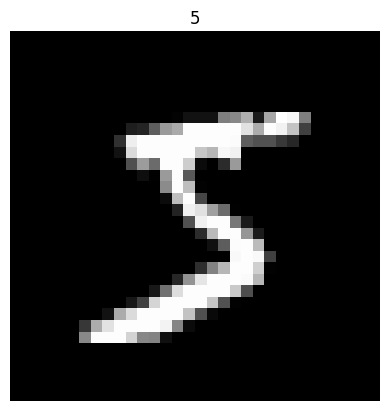

In [15]:
sample, label = mnist_train_data[0]
plt.title(label)
plt.axis("off")
plt.imshow(sample.squeeze(), cmap="grey");

In [16]:
sample.max(), sample.min()  # relatively similar

(tensor(1.1429), tensor(0.))

In [17]:
mnist_train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=2, fill=0, padding_mode=constant)
               Normalize(mean=(0,), std=(0.875,))
           )

## 2) Data Preprocessing
Data Is Preprocessed (thankfully) & I need to feed it to DataLoader

In [18]:
train_dataloader = DataLoader(
    mnist_train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    mnist_test_data,
    batch_size=32,
    shuffle=False
)

## 3) Original LeNet-5 (kind of)
Differences:<br>
1) I'll connect all feature maps between S2 and C3<br>
2) I'm not using coefficient and bias with sigmoid in subsampling. Just Average Pooling.<br>
3) Softmax instead of RBF<br>
4) Replaced last convolution with flatten.

---
In other words I got rid of nearly all old concepts

In [160]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.layerstack = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(6, 16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(2, 2),
        nn.Flatten(),
        nn.Tanh(),
        nn.Linear(5*5*16, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )

  def forward(self, X):
    return self.layerstack(X)

In [161]:
og_lenet = LeNet5().to("cuda")

In [162]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(og_lenet.parameters(), lr=0.1)

In [163]:
def train_step(
            model,
            data_loader,
            loss_fn,
            accuracy_fn,
            optimizer,
            device):
  train_loss = 0
  train_acc = 0

  model.to(device)
  model.train()
  for X, y in data_loader:
    X = X.to(device)
    y = y.to(device)

    logs_pred = model(X)
    loss = loss_fn(logs_pred, y)
    accuracy = accuracy_fn(torch.softmax(logs_pred, dim=1).argmax(dim=1), y)

    train_loss += loss
    train_acc += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.3f}")

def test_step(
            model,
            data_loader,
            loss_fn,
            accuracy_fn,
            device):
  test_loss = 0
  test_acc = 0

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)

      logs_pred = model(X)
      loss = loss_fn(logs_pred, y)
      accuracy = accuracy_fn(torch.softmax(logs_pred, dim=1).argmax(dim=1), y)

      test_loss += loss
      test_acc += accuracy

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.3f}")



In [164]:
def accuracy_fn(y_pred, y):
  return 1 / len(y) * torch.eq(y_pred, y).sum().item()

In [165]:
device = "cuda"
epochs = 6

for epoch in range(epochs):
  print(f"Epoch: {epoch+1}")
  train_step(og_lenet,
             train_dataloader,
             loss_fn,
             accuracy_fn,
             optimizer,
             device
             )
  test_step(og_lenet,
            test_dataloader,
            loss_fn,
            accuracy_fn,
            device)

Epoch: 1
Train Loss: 0.298 | Train Accuracy: 0.912
Test Loss: 0.102 | Test Accuracy: 0.969
Epoch: 2
Train Loss: 0.093 | Train Accuracy: 0.972
Test Loss: 0.068 | Test Accuracy: 0.979
Epoch: 3
Train Loss: 0.064 | Train Accuracy: 0.980
Test Loss: 0.049 | Test Accuracy: 0.985
Epoch: 4
Train Loss: 0.051 | Train Accuracy: 0.985
Test Loss: 0.044 | Test Accuracy: 0.986
Epoch: 5
Train Loss: 0.041 | Train Accuracy: 0.988
Test Loss: 0.042 | Test Accuracy: 0.987
Epoch: 6
Train Loss: 0.036 | Train Accuracy: 0.989
Test Loss: 0.036 | Test Accuracy: 0.988


## Evaluate Model + show it
It's a little bit overfitted, but anyway, 99% performance is slightly better than original LeNet-5

In [166]:
og_lenet.eval()
og_lenet.to("cpu")
with torch.inference_mode():
  predictions = []
  for X, _ in test_dataloader:
    for pred in torch.softmax(og_lenet(X), dim=1).argmax(dim=1):
      predictions.append(pred.item())

predictions[:2]

[7, 2]

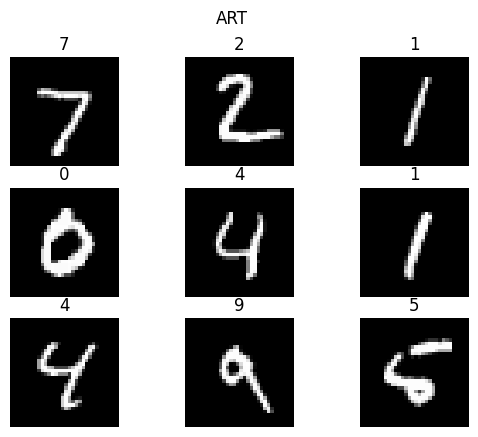

In [167]:
plt.suptitle("ART")
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis("off")
  plt.title(predictions[i])
  plt.imshow(mnist_test_data[i][0].squeeze(), cmap="grey");

In [170]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_5.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=og_lenet.state_dict(), f=MODEL_SAVE_PATH)
print(f"Saved model to: {MODEL_SAVE_PATH}")

Saved model to: models/lenet_5.pth
